# 单细胞转录组与空间转录组整合分析

### Integrating spatial data with scRNA-seq using scanorama

Author: JiaqiLi

Contact: jiaqili@zju.edu.cn

All right reserved.

2021.06.29

==================================================================

本教程展示了如何处理多个 Visium 数据集以及如何将 scRNA-seq 数据集与Scanpy 集成。

遵循先前关于空间转录组学数据分析和可视化的教程。

我们将使用Scanorama 来执行集成 (integration) 和标签传输 (label transfer)

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

In [2]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

## 读取数据

我们将使用小鼠大脑 ( Sagittal) 的两个Visium空间转录组学数据集，这些数据集可从10x 基因组学网站公开获得。

该函数datasets.visium_sge()从 10x 基因组下载数据集，并返回一个包含计数、图像和空间坐标的 AnnData 对象。我们将计算标准 QC 指标pp.calculate_qc_metrics并将其可视化。

使用自己的 Visium 数据时，使用 Scanpy 的read_visium() 功能导入。

In [3]:
adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)

reading /media/ggj/Files/SpatialTranscriptome/Spatial.RNA.intergrate/data/V1_Mouse_Brain_Sagittal_Anterior/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
reading /media/ggj/Files/SpatialTranscriptome/Spatial.RNA.intergrate/data/V1_Mouse_Brain_Sagittal_Posterior/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_spatial_anterior, inplace=True)
sc.pp.calculate_qc_metrics(adata_spatial_posterior, inplace=True)

/home/ggj/anaconda3/envs/SpatialTransriptome/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


/home/ggj/anaconda3/envs/SpatialTransriptome/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ggj/anaconda3/envs/SpatialTransriptome/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ggj/anaconda3/envs/SpatialTransriptome/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

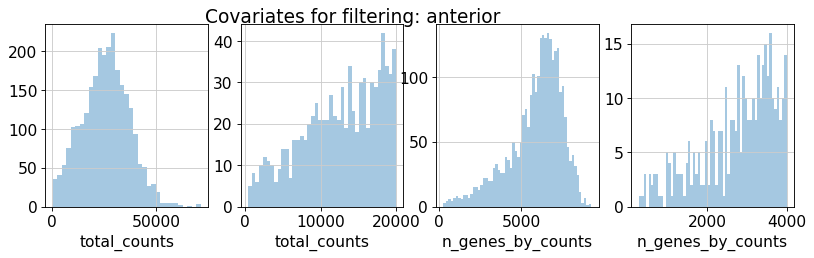

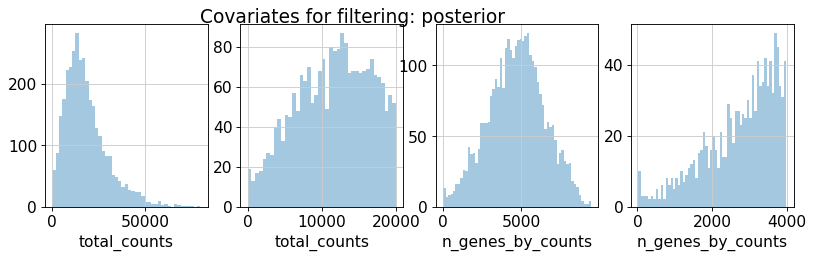

In [6]:
for name, adata in [
    ("anterior", adata_spatial_anterior),
    ("posterior", adata_spatial_posterior),
]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )

sc.datasets.visium_sge下载过滤后的visium 数据集，即仅包含组织切片内点的间隔器的输出。

事实上，查看标准 QC 指标，我们可以观察到样本不包含空点。

我们继续使用 Scanpy 的内置normalize_total方法对 Visium 计数数据进行标准化，并检测高度可变的基因

In [7]:
for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]:
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## 数据整合

我们现在准备使用 Scanorama 执行两个数据集的集成。

对于每个数据集，Scanorama 返回两个列表，一个用于集成嵌入，另一个用于校正计数。

使用 BBKNN 或 Ingest 也是可能的。

In [8]:
adatas = [adata_spatial_anterior, adata_spatial_posterior]
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 32285 genes among all datasets
[[0.         0.47600596]
 [0.         0.        ]]
Processing datasets (0, 1)


我们将连接两个数据集并将集成的嵌入保存在adata_spatial.obsm['scanorama_embedding']. 

我们将计算 UMAP 以可视化结果并定性评估数据集成任务。

我们正在使用uns_merge="unique"策略连接两个数据集，以便在连接的 anndata 对象中保留来自 visium 数据集的两个图像。

In [9]:
adata_spatial = adatas_cor[0].concatenate(
    adatas_cor[1],
    batch_key="library_id",
    uns_merge="unique",
    batch_categories=[
        k
        for d in [
            adatas_cor[0].uns["spatial"],
            adatas_cor[1].uns["spatial"],
        ]
        for k, v in d.items()
    ],
)

In [10]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Leiden clustering
    finished: found 22 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


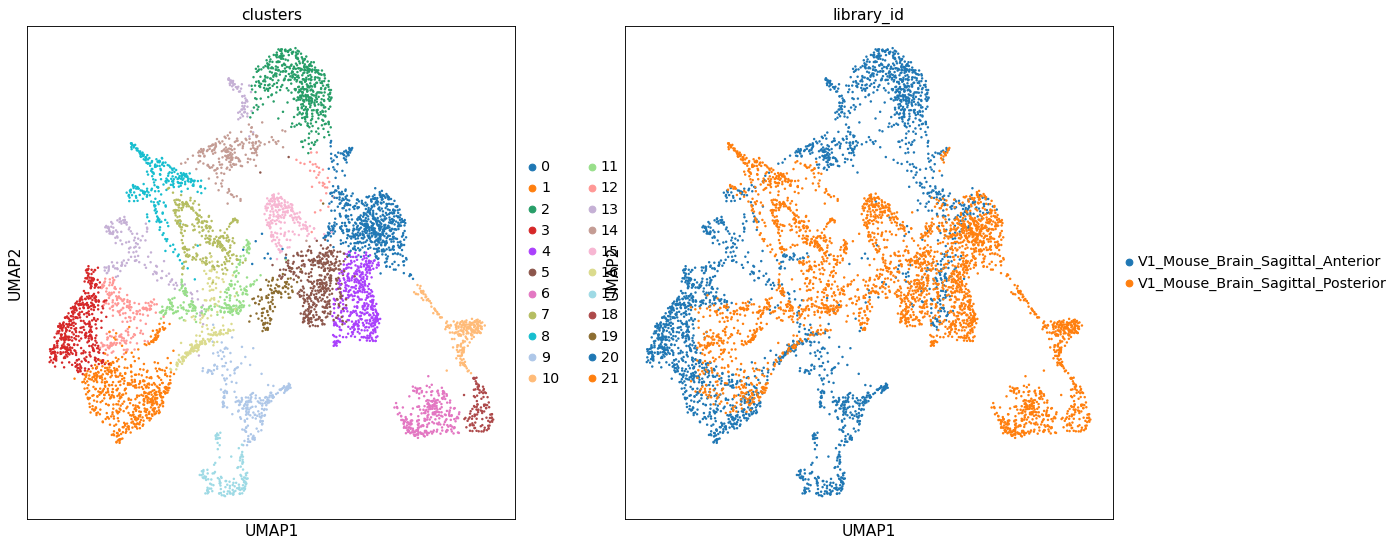

In [11]:
sc.pl.umap(
    adata_spatial, color=["clusters", "library_id"], palette=sc.pl.palettes.default_20
)

在空间坐标中可视化聚类结果

我们首先需要将簇颜色保存在字典中。然后，我们可以绘制前后矢状视图的 Visium 组织，并排在一起。

In [12]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"])
)

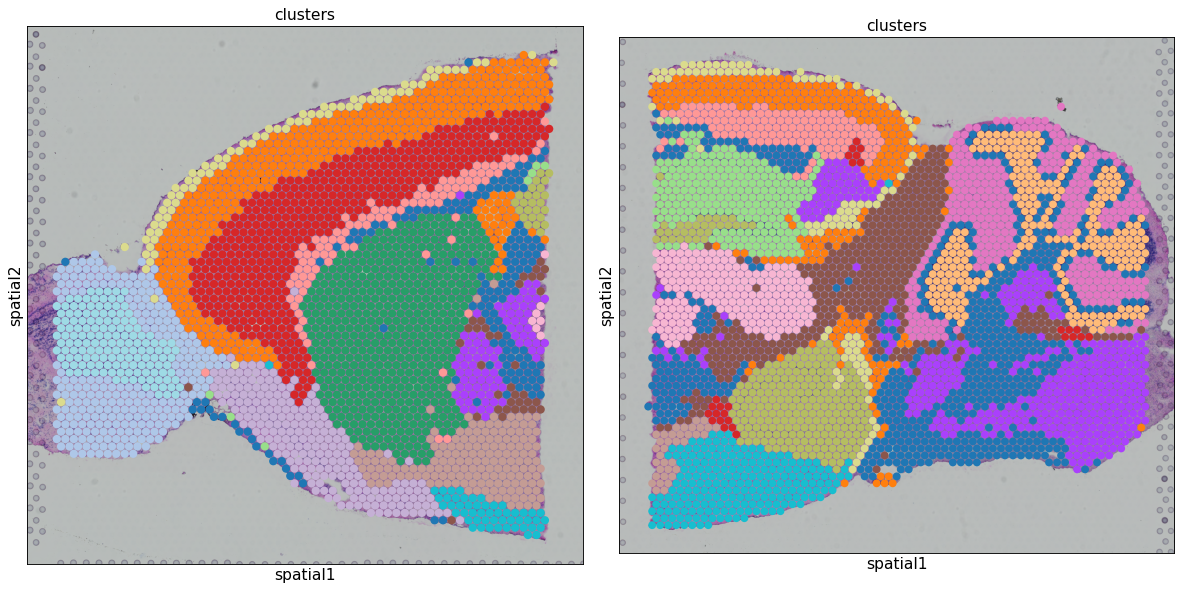

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

从 clusters 集群中，我们可以清楚地看到两种组织中皮质层的分层（参见 Allen brain atlas 以供参考）。

数据集集成 dataset integration 结果良好，因为两个组织中的集群之间存在明显的连续性。

## scRNA-seq 数据集的数据集成和标签转移

scRNA-seq 数据集和空间转录组学数据集之间进行数据整合

允许我们将细胞类型标签转移到 Visium 数据集，这些数据集是从 scRNA-seq 数据集中识别的。

对于这项任务，我们将使用来自 Tasic et al. 数据集。使用 smart-seq 技术对小鼠皮层进行了分析。

数据集可以从`GEO <https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115746>`下载

由于数据集是从鼠标皮层生成的，我们将对 visium 数据集进行 subset，以便仅选择皮层的 spot 部分。

数据整合 integration 也可以在整个大脑切片上执行，但它会导致假阳性细胞类型分配，应该小心。

集成任务将使用 Scanorama 执行：每个 Visium 数据集将与 smart-seq cortex 数据集集成。

In [14]:
adata_cortex = sc.read("./data/adata_processed.h5ad")
adata_cortex

/home/ggj/anaconda3/envs/SpatialTransriptome/lib/python3.6/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/ggj/anaconda3/envs/SpatialTransriptome/lib/python3.6/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 22272 × 36577
    obs: 'title', 'source_name', 'organism', 'donor_id', 'donor_sex', 'donor_genotype', 'injection_type', 'injection_target', 'injected_material', 'dissected_region', 'dissected_layer', 'facs_gating', 'facs_date', 'rna_amplification_set', 'sequencing_tube', 'sequencing_batch', 'sequencing_qc_pass_fail', 'cell_class', 'cell_subclass', 'cell_cluster', 'molecule', 'SRA_Run', 'GEO_Sample', 'GEO_Sample_Title', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap

In [23]:
sc.pp.subsample(adata_cortex, fraction=0.3)
adata_cortex

AnnData object with n_obs × n_vars = 6681 × 36577
    obs: 'title', 'source_name', 'organism', 'donor_id', 'donor_sex', 'donor_genotype', 'injection_type', 'injection_target', 'injected_material', 'dissected_region', 'dissected_layer', 'facs_gating', 'facs_date', 'rna_amplification_set', 'sequencing_tube', 'sequencing_batch', 'sequencing_qc_pass_fail', 'cell_class', 'cell_subclass', 'cell_cluster', 'molecule', 'SRA_Run', 'GEO_Sample', 'GEO_Sample_Title', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'

将空间 Anndata 子集 subset 到（大约）仅选择属于皮层的点

In [24]:
adata_anterior_subset = adata_spatial_anterior[
    adata_spatial_anterior.obsm["spatial"][:, 1] < 6000, :
]

adata_posterior_subset = adata_spatial_posterior[
    (adata_spatial_posterior.obsm["spatial"][:, 1] < 4000)
    & (adata_spatial_posterior.obsm["spatial"][:, 0] < 6000),
    :,
]

/home/ggj/anaconda3/envs/SpatialTransriptome/lib/python3.6/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


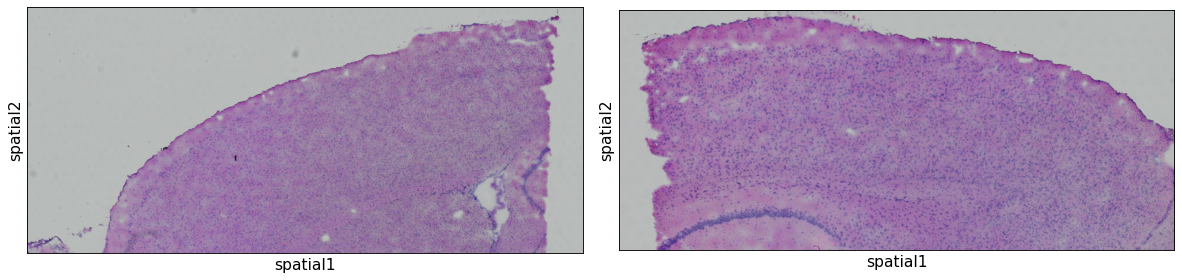

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, ad in enumerate([adata_anterior_subset, adata_posterior_subset]):
    sc.pl.spatial(ad, img_key="hires", ax=axs[i], legend_loc=None, show=False)
    
# for ad, library in zip(
#     [adata_anterior_subset, adata_posterior_subset],
#     ["V1_Mouse_Brain_Sagittal_Anterior_subset", "V1_Mouse_Brain_Sagittal_Posterior_subset"]
# ):
#     ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
#     sc.pl.spatial(
#         ad,
#         img_key="hires",
#         library_id=library,
#         color="clusters",
#         size=1.5,
#         palette=[
#             v
#             for k, v in clusters_colors.items()
#             if k in ad.obs.clusters.unique().tolist()
#         ],
#         legend_loc=None,
#         show=False,
#         ax=axs[i],
#     )

plt.tight_layout()

## Run integration with Scanorama

这一步可能会占用大量计算时间

In [26]:
adatas_anterior = [adata_cortex, adata_anterior_subset]
adatas_posterior = [adata_cortex, adata_posterior_subset]

# Integration.
integrated_anterior, corrected_anterior = scanorama.correct_scanpy(
    adatas_anterior, return_dimred=True
)
integrated_posterior, corrected_posterior = scanorama.correct_scanpy(
    adatas_posterior, return_dimred=True
)

Found 20538 genes among all datasets
[[0.         0.16770186]
 [0.         0.        ]]
Processing datasets (0, 1)
Found 20538 genes among all datasets
[[0.         0.27702703]
 [0.         0.        ]]
Processing datasets (0, 1)


连接数据集并将 integrated embeddings 集成嵌入 分配给 anndata 对象。

我们正在将数据集与 ```join="outer"``` 和```uns_merge="first"```策略连接起来。

因为我们想要保留 ```obsm['coords']visium``` 数据集的图像

In [27]:
adata_cortex_anterior = adata_cortex.concatenate(
    adata_anterior_subset,
    batch_key="dataset",
    batch_categories=["smart-seq", "visium"],
    join="outer",
    uns_merge="first",
)
adata_cortex_posterior = adata_cortex.concatenate(
    adata_posterior_subset,
    batch_key="dataset",
    batch_categories=["smart-seq", "visium"],
    join="outer",
    uns_merge="first",
)

In [21]:
%%time

embedding_anterior = np.concatenate([integrated_anterior.obsm['X_scanorama'], corrected_anterior.obsm['X_scanorama']], axis=0)
adata_cortex_anterior.obsm["scanorama_embedding"] = embedding_anterior

embedding_posterior = np.concatenate([integrated_posterior.obsm['X_scanorama'], corrected_posterior.obsm['X_scanorama']], axis=0)
adata_cortex_posterior.obsm["scanorama_embedding"] = embedding_posterior

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 6.5 ms


我们已经将每个 visium 数据集与 scRNA-seq 数据集 集成到一个公共嵌入 embedding 中

在这样的嵌入空间中，我们可以计算样本之间的距离，并将这些距离用作权重，用于将标签从 scRNA-seq 数据集传播到 Visium 数据集。

这种方法与TransferData Seurat 中的函数非常相似

1. 首先，我们在公共嵌入空间中计算 visium 数据集和 scRNA-seq 数据集之间的余弦距离

In [22]:
from sklearn.metrics.pairwise import cosine_distances

distances_anterior = 1 - cosine_distances(
    adata_cortex_anterior[adata_cortex_anterior.obs.dataset == "smart-seq"].obsm[
        "scanorama_embedding"
    ],
    adata_cortex_anterior[adata_cortex_anterior.obs.dataset == "visium"].obsm[
        "scanorama_embedding"
    ],
)
distances_posterior = 1 - cosine_distances(
    adata_cortex_posterior[adata_cortex_posterior.obs.dataset == "smart-seq"].obsm[
        "scanorama_embedding"
    ],
    adata_cortex_posterior[adata_cortex_posterior.obs.dataset == "visium"].obsm[
        "scanorama_embedding"
    ],
)

2. 然后，我们将标签从 scRNA-seq 数据集传播到 visium 数据集

In [23]:
def label_transfer(dist, labels):
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

In [24]:
class_prob_anterior = label_transfer(distances_anterior, adata_cortex.obs.cell_subclass)
class_prob_posterior = label_transfer(
    distances_posterior, adata_cortex.obs.cell_subclass
)

```class_prob_[anterior-posterior]```对象是形状的numpy的阵列，其中包含分配的权重的每个点到每个细胞类型```(cell_type, visium_spots)```

从表达谱的角度来看，这个值基本上告诉我们这些点与来自 scRNA-seq 数据集的所有其他注释细胞类型的相似程度。

我们将```class_prob_[anterior-posterior]```对象转换为数据帧并将其分配给相应的 anndata

In [25]:
cp_anterior_df = pd.DataFrame(
    class_prob_anterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique())
)
cp_posterior_df = pd.DataFrame(
    class_prob_posterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique())
)

cp_anterior_df.index = adata_anterior_subset.obs.index
cp_posterior_df.index = adata_posterior_subset.obs.index

In [26]:
adata_anterior_subset_transfer = adata_anterior_subset.copy()
adata_anterior_subset_transfer.obs = pd.concat(
    [adata_anterior_subset.obs, cp_anterior_df], axis=1
)

adata_posterior_subset_transfer = adata_posterior_subset.copy()
adata_posterior_subset_transfer.obs = pd.concat(
    [adata_posterior_subset.obs, cp_posterior_df], axis=1
)

然后我们能够探索细胞类型如何从 scRNA-seq 数据集传播到 visium 数据集。让我们首先可视化神经元皮质层。

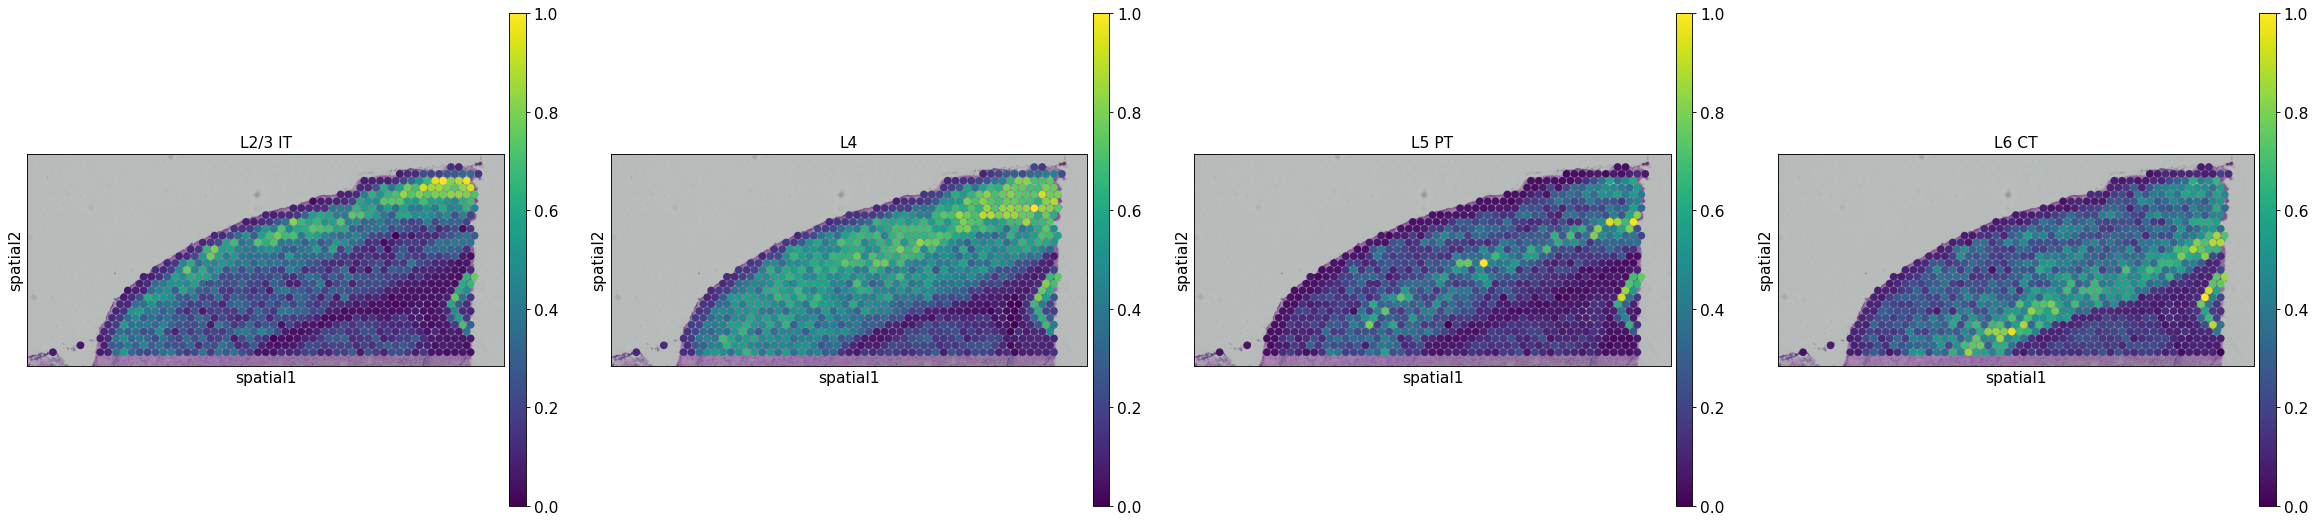

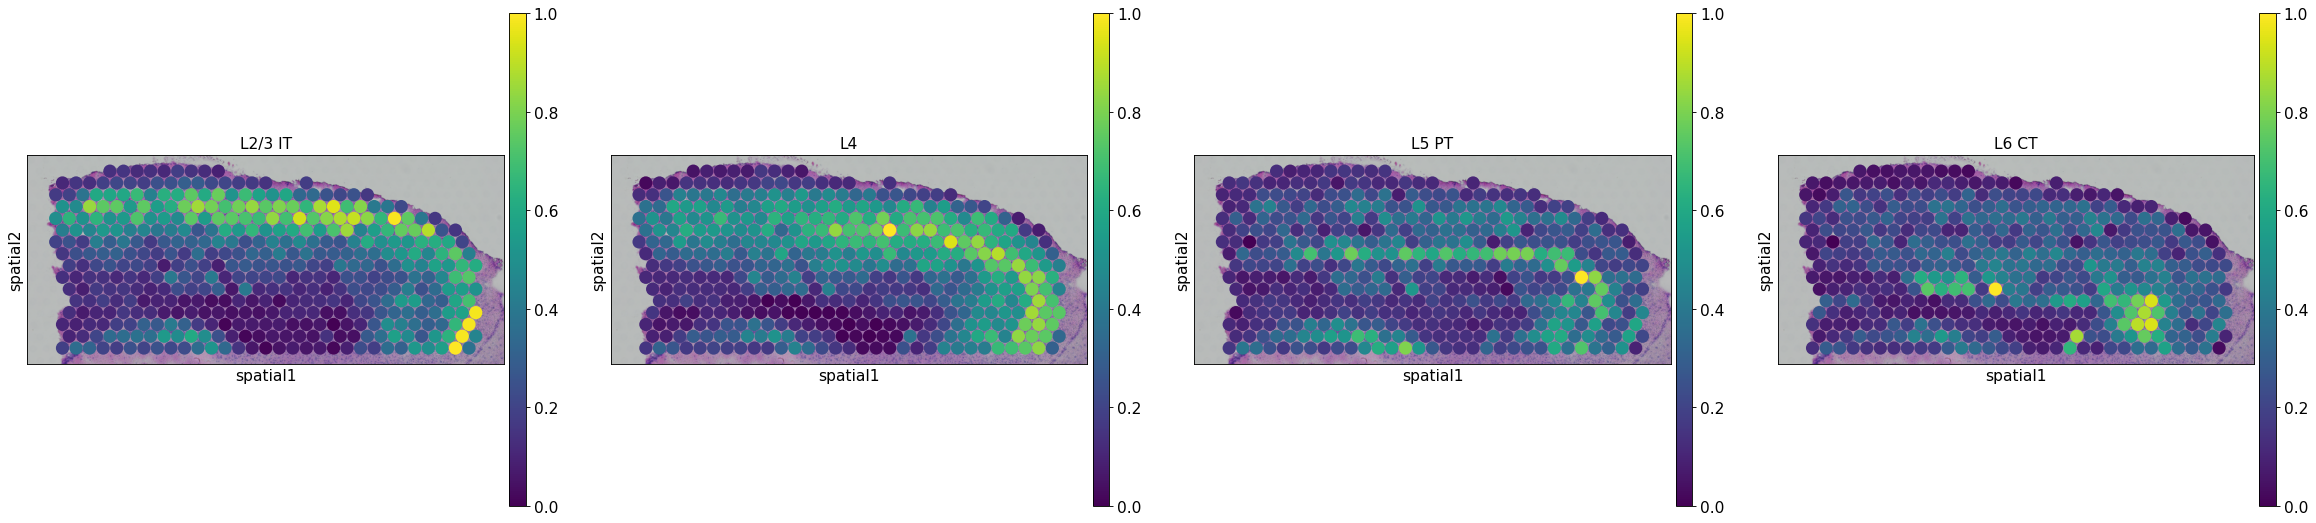

In [27]:
sc.pl.spatial(
    adata_anterior_subset_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
)
sc.pl.spatial(
    adata_posterior_subset_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
)

可以正确识别前后矢状滑动中的连续皮质神经元层。

我们也可以继续可视化星形胶质细胞和少突胶质细胞

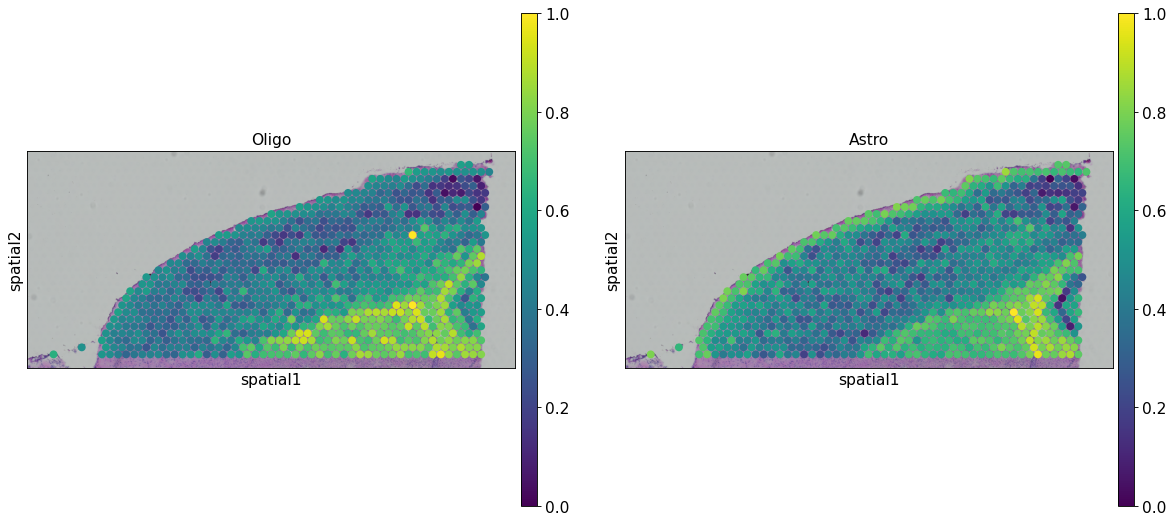

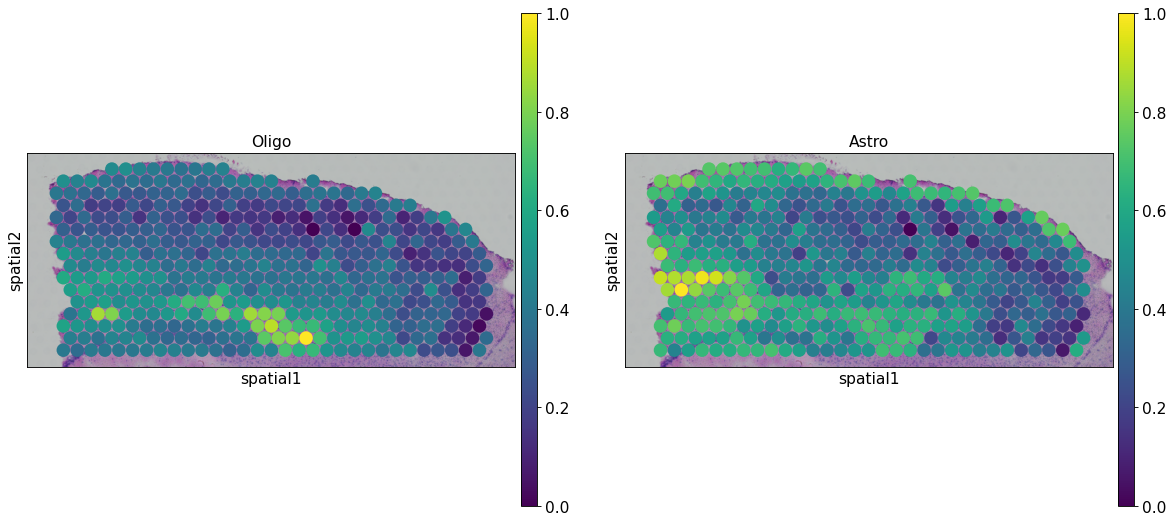

In [28]:
sc.pl.spatial(
    adata_anterior_subset_transfer, img_key="hires", color=["Oligo", "Astro"], size=1.5
)
sc.pl.spatial(
    adata_posterior_subset_transfer, img_key="hires", color=["Oligo", "Astro"], size=1.5
)

==================================================================

# 总结

如何在 Scanpy 中处理多个切片，并在带注释的 scRNA-seq 数据集和未注释的 Visium 数据集之间执行数据整合。

利用 Scanorama 数据集成性能的方法是有用的，并且为探索性分析提供了一个简单的工具

一些更高级的方法

基于细胞类型反卷积

- Stereoscope
- AutogeneS
- MuSiC
- CIBERSORT-X
- Deconv-seq
- cell2location

In [30]:
import dill
# dill.dump_session("./session/spatial.RNA.intergrate.pkl")
dill.load_session("./session/spatial.RNA.intergrate.pkl")